## Problems

### Conversion
1.	Is it possible to predict customer conversion (from viewing to purchasing)?
2.	Can we identify “new customers”? If yes then what is the best strategy to work with them?
3.	What are the top features that define customer conversion?
4.	Can we explain and visualize the predictive model for customer conversion on a journey and at a session level?
5.	Is there a pattern and trend across product types regarding the conversion event?

### Personalization
1.	Can we personalize the experience from customer-product interactions?
2.	Does the product catalogue information help in improving customer experience?
3.	Can personalized shopping experience be predictively modeled?
4.	Can we apply transfer learning from other E-commerce data sets to our local data set?

In [1]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip install -r requirements.txt
!pip install tensorflow-addons
!pip install shap
!pip install dask
!pip install dask-ml

     |████████████████████████████████| 94 kB 3.8 MB/s  eta 0:00:01
     |████████████████████████████████| 166.7 MB 116.4 MB/s eta 0:00:01
     |████████████████████████████████| 87 kB 11.4 MB/s  eta 0:00:01
     |████████████████████████████████| 170 kB 125.4 MB/s eta 0:00:01
     |███████████████████████████▋    | 276.3 MB 121.6 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 320.4 MB 43 kB/s 
     |████████████████████████████████| 356 kB 103.6 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 115.3 MB/s eta 0:00:01
     |████████████████████████████████| 288 kB 111.1 MB/s eta 0:00:01
     |████████████████████████████████| 459 kB 81.3 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 78.7 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 123.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 67.4 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 940 kB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 4.2 MB/s s eta 0:00:01
     |████████████████████████████████| 26.1 MB 106.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.2 MB 91.5 MB/s eta 0:00:01
     |████████████████████████████████| 20.1 MB 61.3 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 93.4 MB/s eta 0:00:01
     |████████████████████████████████|

In [1]:
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:35929 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 66.01 GB


## Preprocessing

In [2]:
from groupby_user_conversion import GroupBy, FeatureSelection, Evaluation

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
Using TensorFlow backend.


In [3]:
g = GroupBy('raw_data.json')
preprocessed_data = g.preprocessing_for_bin_class()

In [142]:
features = preprocessed_data['features'][preprocessed_data['features']['productPriceMean'] > 0]
label = preprocessed_data['label'][preprocessed_data['features']['productPriceMean'] > 0]

# features = preprocessed_data['features'][preprocessed_data['features']['timeOnSiteSeconds'] > 0]
# label = preprocessed_data['label'][preprocessed_data['features']['timeOnSiteSeconds'] > 0]

features = features.drop(columns=['sessionDuration','timeOnSiteSeconds','os','source','deviceCategory','events',
                                  'bounce','has_campaign','browser'])
all_os = preprocessed_data['all_os']
all_source = preprocessed_data['all_source']

Feature "uniqueNavigations" is highly related to "uniqueRefinements". Remove "uniqueNavigations"
Feature "uniqueViewProducts" is highly related to "totalViewProducts". Remove "uniqueViewProducts"
Feature "totalViewProductRevenue" is highly related to "totalViewProducts". Remove "totalViewProductRevenue"
Feature "uniqueAddToCarts" is highly related to "totalAddToCarts". Remove "uniqueAddToCarts"
Feature "totalAddToCartRevenue" is highly related to "totalAddToCarts". Remove "totalAddToCartRevenue"
19


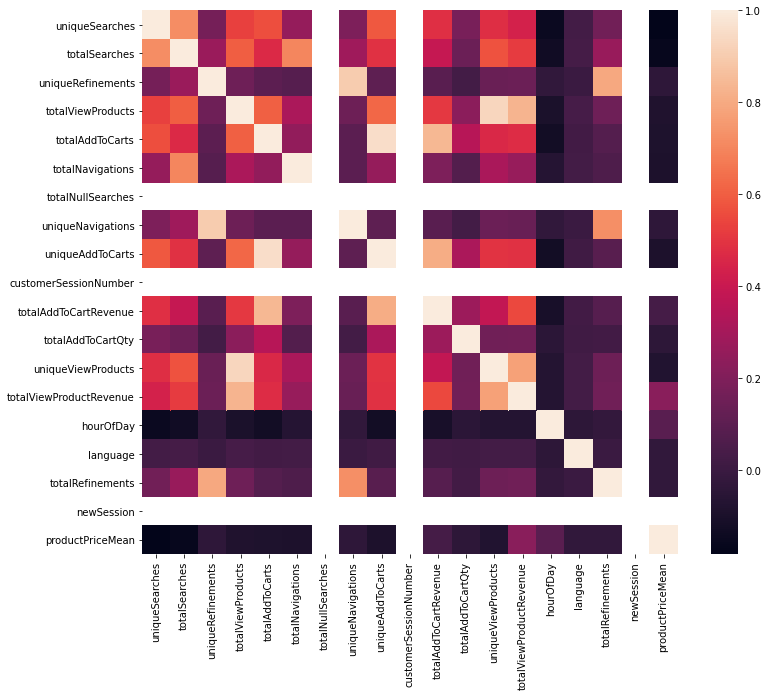

               score            feature
feature 3   0.072150  totalViewProducts
feature 8   0.057693  totalAddToCartQty
feature 4   0.057067    totalAddToCarts
feature 13  0.040262   productPriceMean
feature 9   0.039301          hourOfDay
feature 0   0.021227     uniqueSearches
feature 1   0.020520      totalSearches


In [143]:
# Select features
new_features = FeatureSelection.by_coorelation(features, debug=True)
new_features = FeatureSelection.by_permutation_importance(x=new_features, y=label, debug=True)

In [144]:
filtered_new_features = new_features
filtered_label = label

In [148]:
conversion_rate = filtered_label[filtered_label['has_purchase']==1].count()*100/len(filtered_label)
print(f'Conversion Rate is: {conversion_rate["has_purchase"]}%')
      

Conversion Rate is: 8.958713357141022%


In [149]:
scale_pos_weight = filtered_label[filtered_label['has_purchase']==0].count() / filtered_label[filtered_label['has_purchase']==1].count()
scale_pos_weight

has_purchase    10.162317
dtype: float64

## Model Training

In [150]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(
    filtered_new_features.values, filtered_label, test_size=0.33, random_state=42)

In [132]:
import pickle
pickle.dump(y_test, open("y_test","wb"))

In [151]:
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42, scoring="f1",use_dask=True)
tpot.fit(x_train, y_train.values.ravel())

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6312639239122475

Generation 2 - Current best internal CV score: 0.6404350680880617

Generation 3 - Current best internal CV score: 0.6404350680880617

Generation 4 - Current best internal CV score: 0.6407909961735299

Generation 5 - Current best internal CV score: 0.6437939575835527

Best pipeline: GaussianNB(DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=3, min_samples_leaf=16, min_samples_split=16))


TPOTClassifier(generations=5, population_size=50, random_state=42, scoring='f1',
               use_dask=True, verbosity=2)

In [154]:
tpot.export('best_model_pipeline.py')

In [153]:
results = tpot.predict(x_test)
Evaluation.evaluate_model(x_test, y_test, tpot)

,0,1,accuracy,macro avg,weighted avg
precision,0.974275,0.552511,0.923939,0.763393,0.936909
recall,0.941403,0.744288,0.923939,0.842845,0.923939
f1-score,0.957557,0.634219,0.923939,0.795888,0.928911
support,11707.000000,1138.000000,0.923939,12845.000000,12845.000000


In [156]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from xgboost import XGBClassifier
from tpot.export_utils import set_param_recursive


exported_pipeline = make_pipeline(
    StackingEstimator(estimator=XGBClassifier(learning_rate=0.001, max_depth=6, min_child_weight=10, n_estimators=100, n_jobs=1, subsample=0.4, verbosity=0)),
    GaussianNB()
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(x_train, y_train)
results = exported_pipeline.predict(x_test)

Evaluation.evaluate_model(x_test, y_test, exported_pipeline)

,0,1,accuracy,macro avg,weighted avg
precision,0.975851,0.561688,0.926197,0.768770,0.939159
recall,0.942342,0.760105,0.926197,0.851224,0.926197
f1-score,0.958804,0.646004,0.926197,0.802404,0.931092
support,11707.000000,1138.000000,0.926197,12845.000000,12845.000000


In [94]:
from joblib import dump, load
dump(exported_pipeline, 'stacking.joblib') 

['stacking.joblib']

## Sequential Model Training

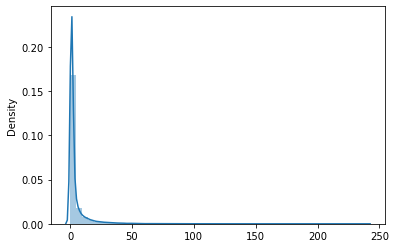

In [8]:
preprocessed_data_for_lstm = g.preprocessing_for_sequence_model(num_of_events=40, debug=True)

Epoch 1/100
27/27 [==============================] - 1s 50ms/step - loss: 0.6594 - f1_score: 0.5018 - val_loss: 0.6180 - val_f1_score: 0.4800
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 0.5747 - f1_score: 0.4854 - val_loss: 0.5222 - val_f1_score: 0.4908
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 0.4714 - f1_score: 0.5321 - val_loss: 0.4174 - val_f1_score: 0.5628
Epoch 4/100
27/27 [==============================] - 0s 10ms/step - loss: 0.3726 - f1_score: 0.5754 - val_loss: 0.3280 - val_f1_score: 0.5283
Epoch 5/100
27/27 [==============================] - 0s 10ms/step - loss: 0.3001 - f1_score: 0.5472 - val_loss: 0.2688 - val_f1_score: 0.5233
Epoch 6/100
27/27 [==============================] - 0s 10ms/step - loss: 0.2561 - f1_score: 0.5582 - val_loss: 0.2360 - val_f1_score: 0.5428
Epoch 7/100
27/27 [==============================] - 0s 10ms/step - loss: 0.2331 - f1_score: 0.5671 - val_loss: 0.2184 - val_f1_score: 0.5609
Epoch 

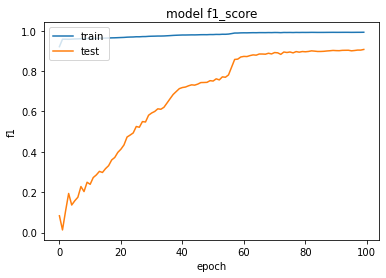

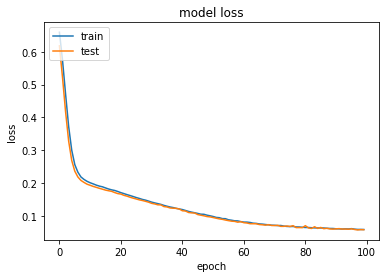

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy: 0.982808
Precision: 0.937931
Recall: 0.840247
F1 score: 0.886406


In [4]:
lstm_model, test_x, test_y, train_x, train_y = GroupBy.train_lstm(
    preprocessed_data_for_lstm['features'], preprocessed_data_for_lstm['label'], threshold=0.5, epochs=100,op=40)
Evaluation.plot_history(lstm_model.history)
Evaluation.evaluate_nn_model(test_x, test_y, lstm_model)

Epoch 1/100
27/27 [==============================] - 1s 50ms/step - loss: 0.6547 - f1_score: 0.0000e+00 - val_loss: 0.6129 - val_f1_score: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 0.5691 - f1_score: 0.0028 - val_loss: 0.5169 - val_f1_score: 0.0207
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 0.4661 - f1_score: 0.0889 - val_loss: 0.4110 - val_f1_score: 0.1879
Epoch 4/100
27/27 [==============================] - 0s 10ms/step - loss: 0.3692 - f1_score: 0.2219 - val_loss: 0.3230 - val_f1_score: 0.2680
Epoch 5/100
27/27 [==============================] - 0s 10ms/step - loss: 0.2980 - f1_score: 0.4021 - val_loss: 0.2660 - val_f1_score: 0.4722
Epoch 6/100
27/27 [==============================] - 0s 10ms/step - loss: 0.2556 - f1_score: 0.4708 - val_loss: 0.2344 - val_f1_score: 0.4697
Epoch 7/100
27/27 [==============================] - 0s 10ms/step - loss: 0.2335 - f1_score: 0.4678 - val_loss: 0.2175 - val_f1_score: 0.466

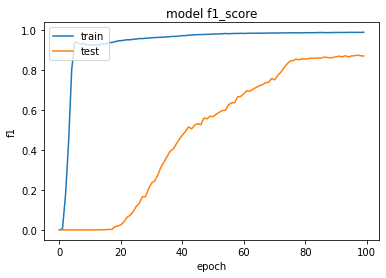

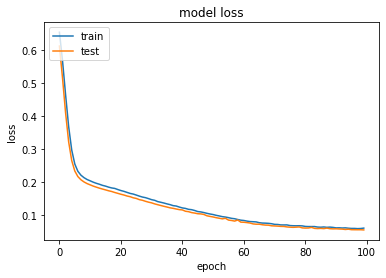

Accuracy: 0.981822
Precision: 0.934476
Recall: 0.827679
F1 score: 0.877841


In [5]:
lstm_model, test_x, test_y, train_x, train_y = GroupBy.train_lstm(
    preprocessed_data_for_lstm['features'], preprocessed_data_for_lstm['label'], threshold=0.8, epochs=100,op=40)
Evaluation.plot_history(lstm_model.history)
Evaluation.evaluate_nn_model(test_x, test_y, lstm_model)

In [15]:
# lstm_model.save('lstm_model')

INFO:tensorflow:Assets written to: lstm_model/assets


Epoch 1/100
27/27 [==============================] - 1s 49ms/step - loss: 0.6524 - f1_score: 0.0000e+00 - val_loss: 0.6079 - val_f1_score: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 0.5654 - f1_score: 0.0000e+00 - val_loss: 0.5113 - val_f1_score: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 0.4664 - f1_score: 0.0096 - val_loss: 0.4093 - val_f1_score: 0.0278
Epoch 4/100
27/27 [==============================] - 0s 10ms/step - loss: 0.3724 - f1_score: 0.0925 - val_loss: 0.3242 - val_f1_score: 0.1794
Epoch 5/100
27/27 [==============================] - 0s 10ms/step - loss: 0.3031 - f1_score: 0.1887 - val_loss: 0.2678 - val_f1_score: 0.2087
Epoch 6/100
27/27 [==============================] - 0s 10ms/step - loss: 0.2604 - f1_score: 0.2449 - val_loss: 0.2348 - val_f1_score: 0.2404
Epoch 7/100
27/27 [==============================] - 0s 10ms/step - loss: 0.2361 - f1_score: 0.3981 - val_loss: 0.2168 - val_f1_scor

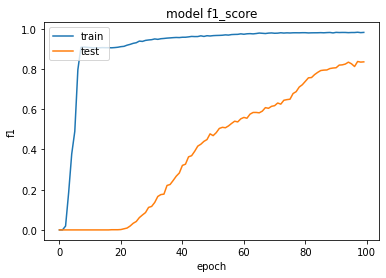

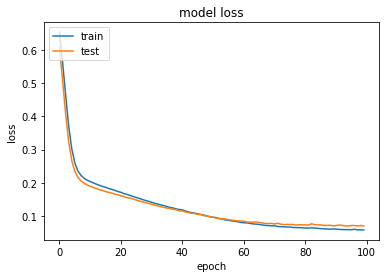

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy: 0.982315
Precision: 0.928778
Recall: 0.845009
F1 score: 0.884915


In [9]:
lstm_model, test_x, test_y, train_x, train_y = GroupBy.train_lstm(
    preprocessed_data_for_lstm['features'], preprocessed_data_for_lstm['label'], threshold=0.9, epochs=100,op=40)
Evaluation.plot_history(lstm_model.history)
Evaluation.evaluate_nn_model(test_x, test_y, lstm_model)

In [28]:
lstm_model.save('lstm_model.h5')

In [27]:
?lstm_model.save

In [11]:
# preprocessed_data_for_lstm['event_type_map']

In [34]:
import pandas as pd
uuu = train_x[pd.DataFrame(train_y, columns=['non_convert','convert'])['convert']==1][10:20]

In [59]:
np.array([0,0,1,0,0,1,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(1,1,-1)

array([[[ 0,  0,  1,  0,  0,  1,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0]]])

In [66]:
!pip list | grep tensor

tensorboard                        2.5.0
tensorboard-data-server            0.6.1
tensorboard-plugin-wit             1.8.0
tensorflow                         2.3.0
tensorflow-addons                  0.13.0
tensorflow-estimator               2.3.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [50]:
uuu.shape

(10, 1, 40)

In [63]:
import numpy as np
from keras.models import load_model
lstm_model_new = load_model('lstm_model.h5')
# lstm_model_new.predict_proba(
#     np.array([0,0,1,0,0,1,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(1,1,-1))
lstm_model_new.predict_proba(
    np.array([0,0,1,0,0,1,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(1,1,-1))

array([[1.5534501e-04, 9.9984467e-01]], dtype=float32)